In [1]:
# general
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.linalg import inv,pinvh,eig,eigh
from scipy.special import gamma
%matplotlib inline
# local
from FBResNet.myfunc import Physics

In [79]:
a     = 1
noise = 0.05

In [80]:
# Matrice opérateur
nx  = 2000
dx  = 1/nx
m   = 50
T   = dx*np.tri(nx)

In [81]:
Ta = np.zeros((nx,nx))
for i in range(nx):
    for j in range(nx):
        if j<=i:
            Ta[i,j]=1/a*dx**(a)*((i-j+1)**a-(i-j)**a)

In [82]:
t   = np.linspace(0,1-1/nx,nx)
x   = np.exp(-(t-0.5)**2/0.1**2)
x   = x/np.amax(x)
y   = Ta.dot(x)

In [89]:
# noise
m = 500
physics     = Physics(nx,m)
vn          = np.zeros(m)
fmax        = 40
vn[fmax:]   = np.random.randn(m-fmax)
vn_elt      = physics.BasisChangeInv(vn)
vn_elt      = vn_elt/np.linalg.norm(vn_elt)
yd          = y + noise*np.linalg.norm(y)*vn_elt

In [90]:
def Fourier_filter(yd,Ta,a,nx,m):
    # adjoint
    Ty     = np.transpose(Ta).dot(yd)
    # Fourier basis       
    h      = 1/(nx-1)
    eig    = (np.linspace(0,m-1,m)+1/2)*np.pi
    eig_m  = eig.reshape(-1,1)
    v1     = ((2*np.linspace(0,nx-1,nx)+1)*h/2).reshape(1,-1)
    v2     = (np.ones(nx)/2*h).reshape(1,-1)
    F      = 2*np.sqrt(2)/eig_m*np.cos(v1*eig_m)*np.sin(v2*eig_m)
    # Invertion
    yfft   = F.dot(Ty)
    xfft   = np.diag(eig**(2*a)).dot(yfft)
    coeff  = 1/gamma(a)**2
    x      = coeff*nx*np.transpose(F).dot(xfft)
    x[4*nx//5:] = np.zeros(nx//5)
    x[:nx//5]   = x[nx//5]*np.ones(nx//5)
    return x

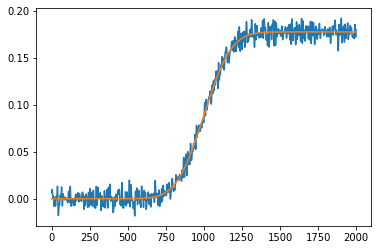

In [91]:
plt.plot(yd)
plt.plot(Ta.dot(x))

In [104]:
xd = Fourier_filter(y,Ta,a,nx,40)

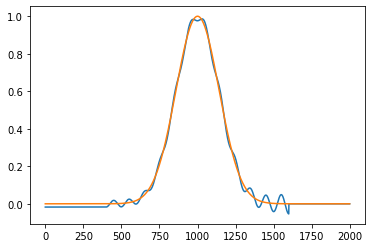

In [105]:
plt.plot(xd)
plt.plot(x)

In [106]:
np.linalg.norm(x-xd)/np.linalg.norm(x)

0.04938892009255984

In [111]:
from FBResNet.posttreat import Export_Data
from scipy.interpolate import interp1d
# interpolation
def reduce(f,n1,n2):
    t      = np.linspace(0,1,n1, endpoint=True)
    te     = np.linspace(0,1,n2,endpoint=True)
    g      = interp1d(t,f)
    f_red  = g(te)
    return te,f_red
t0,f0=reduce(x,nx,500)
Export_Data(t0,f0,'./Redaction/data','gauss')
t1,f1=reduce(xd,nx,500)
Export_Data(t1,f1,'./Redaction/data','gauss_pred_a1_fourier')